# Try a GAN on MNIST

In [1]:
%matplotlib inline
#Import a ton of stuff
import os
import struct
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

from Progbar import Progbar

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Load the MNIST CSV data from https://pjreddie.com/projects/mnist-in-csv/
# data_train = np.genfromtxt('./MNIST_Data/mnist_train.csv', delimiter = ',').astype(np.uint8)
# data_test = np.genfromtxt('./MNIST_Data/mnist_test.csv', delimiter = ',').astype(np.uint8)

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

data_train = read_idx('./MNIST_Data/train-images-idx3-ubyte')
data_test = read_idx('./MNIST_Data/t10k-images-idx3-ubyte')

targets_train = read_idx('./MNIST_Data/train-labels-idx1-ubyte')
targets_test = read_idx('./MNIST_Data/t10k-labels-idx1-ubyte')
print(data_train.shape, data_test.shape, targets_train.shape, targets_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


In [3]:
# Now reformat it into the format we want
# NOTE: PyTorch is weird so if we wanted to use cross entropy we need to keep them as logits, but we won't so...
x_train = np.expand_dims(data_train, 1)
y_train = np.zeros((targets_train.shape[0], 10), dtype = np.uint8)
y_train[np.arange(targets_train.shape[0]), targets_train] = 1

x_test = np.expand_dims(data_test, 1)
y_test = np.zeros((data_test.shape[0], 10), dtype = np.uint8)
y_test[np.arange(targets_test.shape[0]), targets_test] = 1

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Looks like we can convert our x to unint8
# We'll convert back to float and rescale to between 0 and 1 on the GPU batchwise to save CPU RAM
print(np.unique(x_train))
x_train = x_train.astype(np.uint8)
x_test = x_test.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

(60000, 1, 28, 28) (60000, 10)
(10000, 1, 28, 28) (10000, 10)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 2

[0 0 0 0 0 0 0 1 0 0]


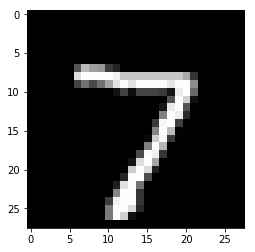

In [4]:
# Show an example from the test set
print(y_test[0])
plt.figure(0)
plt.imshow(x_test[0, 0], cmap = 'gray')

In [5]:
# Prep the data by turning them into tensors and putting them into a PyTorch dataloader
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
train_tensors = TensorDataset(x_train, y_train)
test_tensors = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_tensors, batch_size = 128, shuffle = True, num_workers = 6, pin_memory = True)
test_loader = DataLoader(test_tensors, batch_size = 128, shuffle = True, num_workers = 6, pin_memory = True)

In [6]:
# Now let's start building the GAN
# But first, we're going to redefine Conv2D and Linear with our own initialisations
# We're going to use Glorot (aka Xavier) uniform init for all weights
# And we will use zero init for all biases

c2_len = 2
z_len = 62

class Conv2d(nn.Conv2d):
    def reset_parameters(self):
        stdv = np.sqrt(6 / ((self.in_channels  + self.out_channels) * np.prod(self.kernel_size)))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class ConvTranspose2d(nn.ConvTranspose2d):
    def reset_parameters(self):
        stdv = np.sqrt(6 / ((self.in_channels  + self.out_channels) * np.prod(self.kernel_size)))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class Linear(nn.Linear):
    def reset_parameters(self):
        stdv = np.sqrt(6 / (self.in_features + self.out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = Linear(z_len + 10 + c2_len, 1024)
        self.fc2 = Linear(1024, 7 * 7 * 128)

        self.convt1 = ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1)
        self.convt2 = ConvTranspose2d(64, 1, kernel_size = 4, stride = 2, padding = 1)

        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(7 * 7 * 128)
        self.bn3 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x))).view(-1, 128, 7, 7)

        x = F.relu(self.bn3(self.convt1(x)))
        x = self.convt2(x)

        return F.sigmoid(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = Conv2d(1, 64, kernel_size = 4, stride = 2, padding = 1) # 28 x 28 -> 14 x 14
        self.conv2 = Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1) # 14 x 14 -> 7 x 7

        self.fc1 = Linear(128 * 7 ** 2, 1024)
        self.fc2 = Linear(1024, 1)
        self.fc1_q = Linear(1024, 128)

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm1d(1024)
        self.bn_q1 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.bn1(self.conv2(x))).view(-1, 7 ** 2 * 128)

        x = F.leaky_relu(self.bn2(self.fc1(x)))
        return F.sigmoid(self.fc2(x)), F.leaky_relu(self.bn_q1(self.fc1_q(x)))

In [7]:
# OK, now we create the actual models
gen = Generator().cuda()
dis = Discriminator().cuda()
Q_cat = Linear(128, 10).cuda()
Q_con = Linear(128, c2_len).cuda()

In [8]:
# Create the optimisers
g_optim = optim.Adam(gen.parameters(), lr = 1e-3)
d_optim = optim.Adam(dis.parameters(), lr = 2e-4)
qcat_optim = optim.Adam(Q_cat.parameters(), lr = 2e-4)
qcon_optim = optim.Adam(Q_con.parameters(), lr = 2e-4)

Start training
Epoch  1
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.2230 - loss_gen: 0.5032 - loss_q: 0.2244
Epoch  2
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.2707 - loss_gen: 0.4696 - loss_q: 0.0685
Epoch  3
60000/60000 [==============================] - 19s - loss_dis: 0.3187 - loss_gen: 0.4361 - loss_q: 0.0478    

Epoch  4
60000/60000 [==============================] - 19s - loss_dis: 0.3243 - loss_gen: 0.4348 - loss_q: 0.0419    

Epoch  5
60000/60000 [==============================] - 19s - loss_dis: 0.3228 - loss_gen: 0.4382 - loss_q: 0.0380    

Epoch  6
60000/60000 [==============================] - 21s - loss_dis: 0.3075 - loss_gen: 0.4565 - loss_q: 0.0356    

Epoch  7
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.2897 - loss_gen: 0.4764 - loss_q: 0.0366
Epoch  8
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.2671 - loss_gen: 0.5031 - loss_q: 0.0351
Epoch  9
60000/60000 [=======

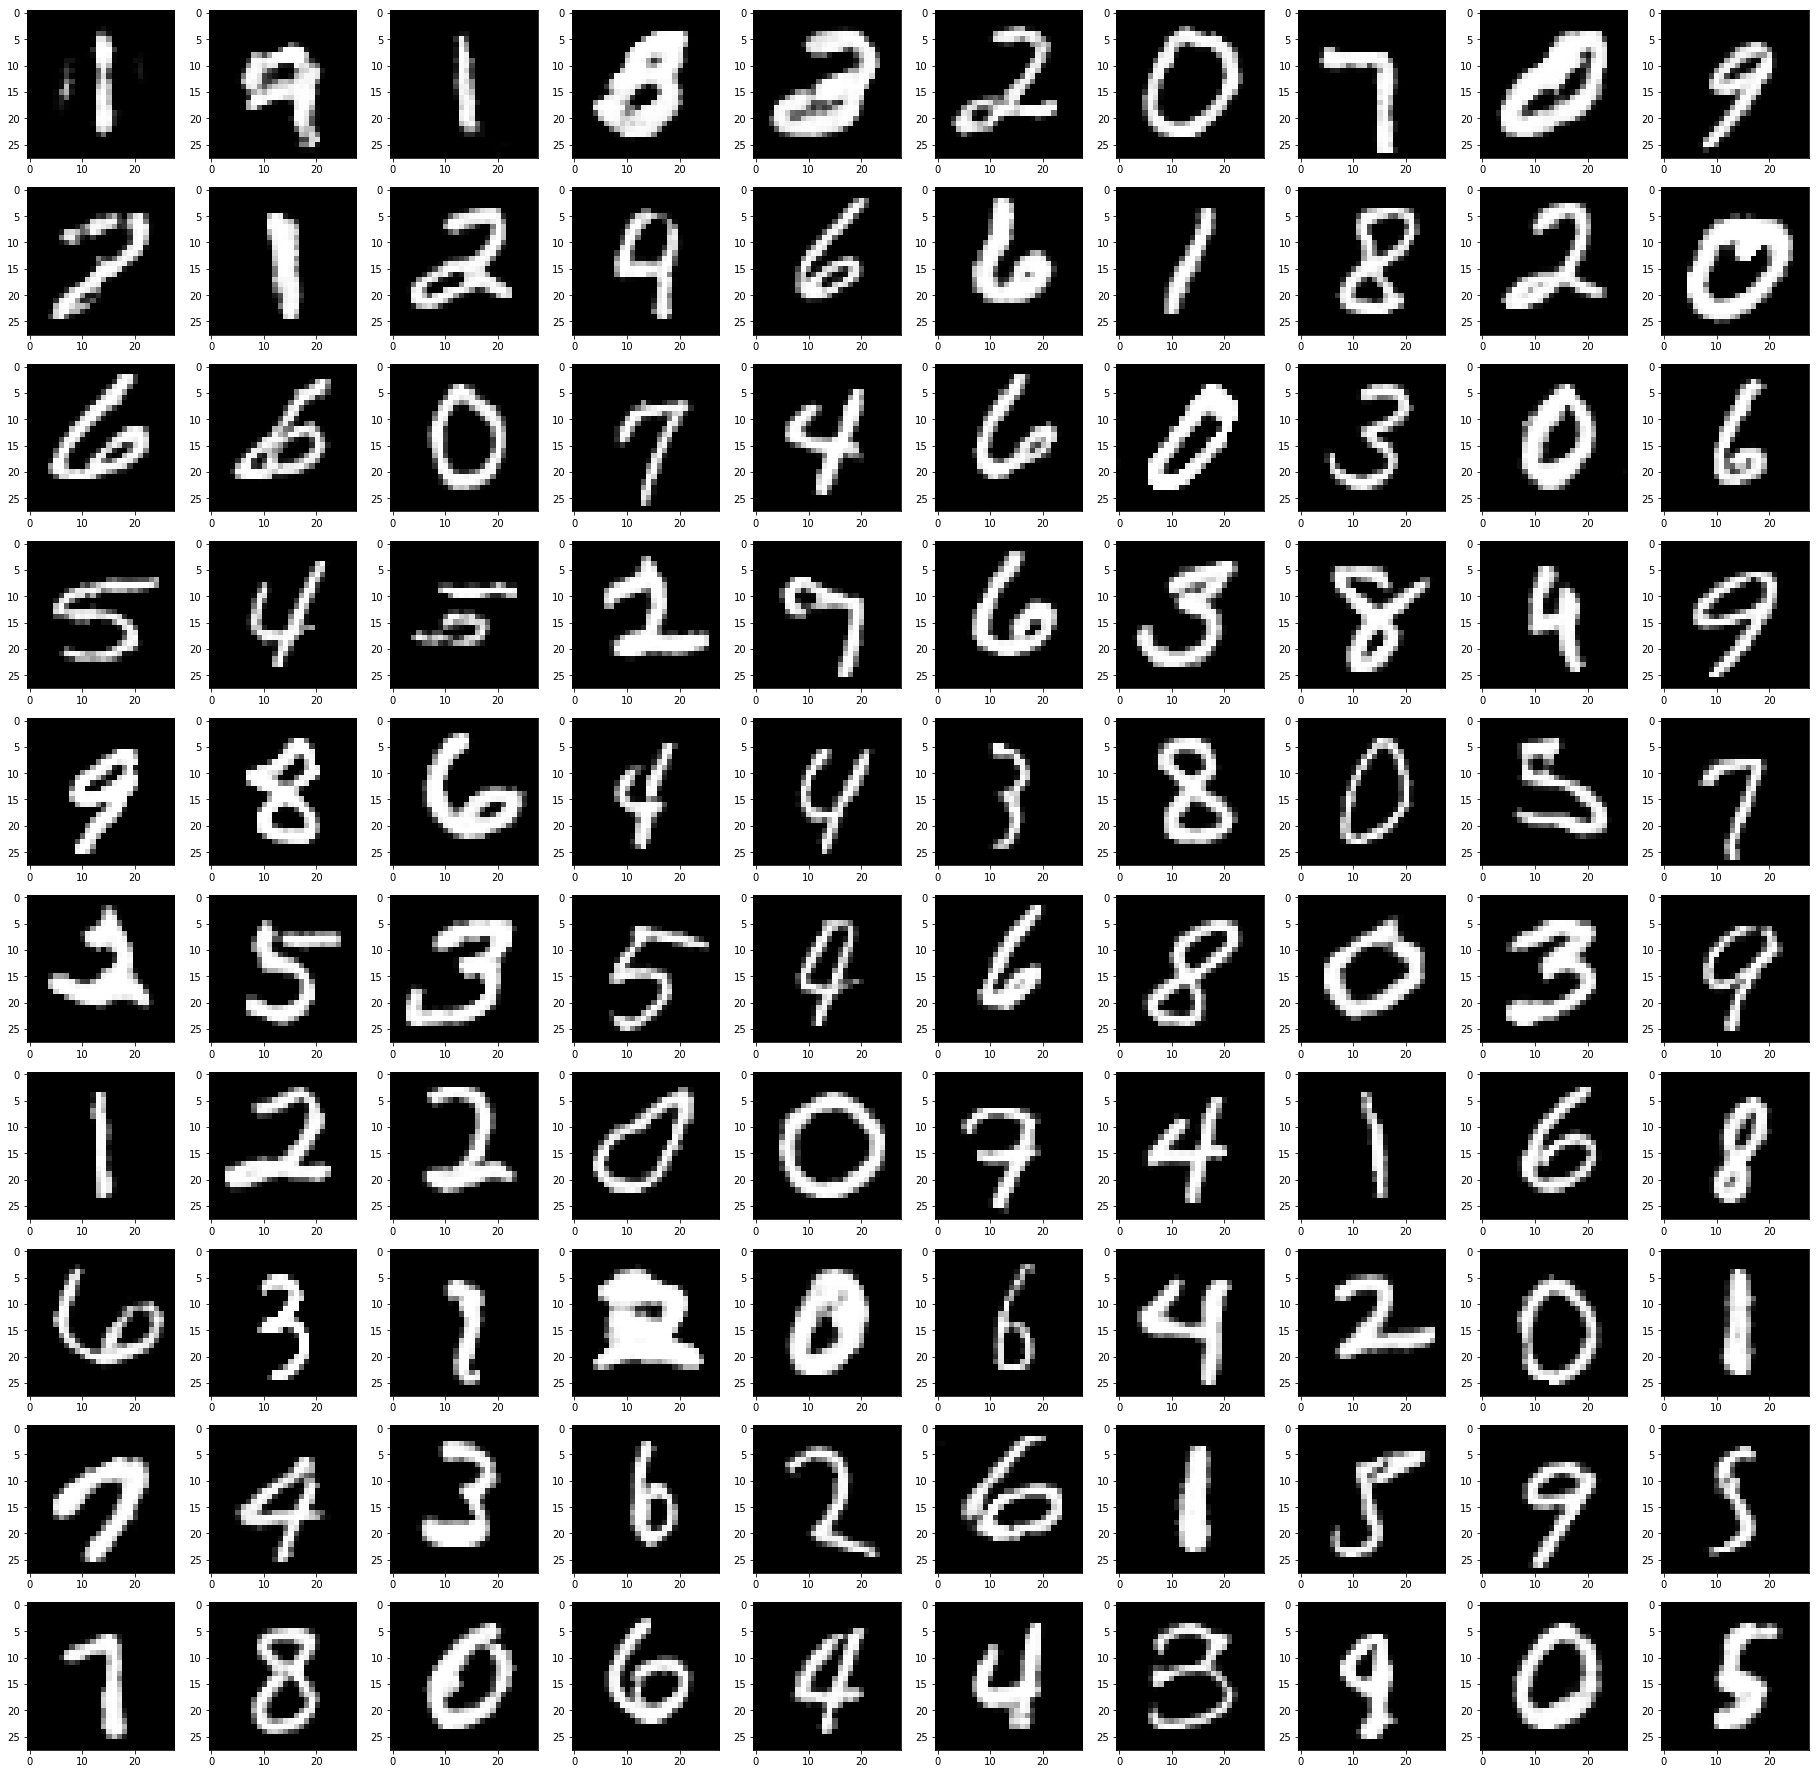

In [19]:
# Alright, everything's setup, let's run the GAN and train it first

nll = nn.NLLLoss().cuda()
mse = nn.MSELoss().cuda()
bce = nn.BCELoss().cuda()

print('Start training')
plt.figure(0, figsize = (32, 32))
for epoch in range(100):
    print('Epoch ', epoch + 1)
    pb = Progbar(x_train.size()[0])
    for i, (data, targets) in enumerate(train_loader, 0):
        ones = Variable(torch.ones(data.size()[0], 1)).cuda()
        zeros = Variable(torch.zeros(data.size()[0], 1)).cuda()
        weights = torch.Tensor([0.1] * 10)
        cat_noise = Variable(torch.multinomial(weights, num_samples = data.size()[0], replacement = True)).cuda()
        #con_noise = Variable(torch.randn(data.size()[0], c2_len)).cuda()
        con_noise = Variable(torch.rand(data.size()[0], c2_len)).cuda() * 2 - 1

        data = Variable(data.float().cuda(async = True)) / 255

        # Train the discriminator
        # Forward pass on real MNIST & Loss
        out_dis, _ = dis(data)
        loss_dis = mse(out_dis, ones)

        # Forward pass on generated MNIST & Loss
        z = Variable(torch.randn(data.size()[0], z_len)).cuda()
        onehot_noise = Variable(torch.zeros(data.size()[0], 10)).cuda()
        onehot_noise.data.scatter_(1, cat_noise.data.view(-1, 1), 1)
        z = torch.cat([z, onehot_noise, con_noise], dim = 1)

        out_gen = gen(z)
        out_dis, _ = dis(out_gen.detach())

        # Now backward pass on discriminator
        loss_dis = loss_dis + mse(out_dis, zeros)
        loss_dis.backward()
        d_optim.step()

        # Forward pass on generated MNIST
        out_dis, _ = dis(out_gen)

        # And backward pass for generator
        gen.zero_grad()
        loss_gen = mse(out_dis, ones)
        loss_gen.backward()
        g_optim.step()

        # Forward pass for latent code
        _, hid = dis(gen(z))
        Q_categorical = F.log_softmax(Q_cat(hid))
        Q_continuous = Q_con(hid)

        # Now latent backward pass for everything
        loss_q = nll(Q_categorical, cat_noise) + 0.5 * mse(Q_continuous, con_noise)
        gen.zero_grad()
        dis.zero_grad()
        Q_cat.zero_grad()
        Q_con.zero_grad()

        loss_q.backward()
        g_optim.step()
        d_optim.step()
        qcat_optim.step()
        qcon_optim.step()

        pb.add(data.size()[0],
               [('loss_dis', loss_dis.cpu().data.numpy()),
                ('loss_gen', loss_gen.cpu().data.numpy()),
                ('loss_q', loss_q.cpu().data.numpy())])

    print()
    plt.subplot(10, 10, epoch + 1)
    plt.imshow(out_gen.cpu().data.numpy()[0, 0], cmap = 'gray')

In [20]:
torch.save(gen.state_dict(), 'mnist_gen.torch')
torch.save(dis.state_dict(), 'mnist_dis.torch')
torch.save(Q_cat.state_dict(), 'mnist_qcat.torch')
torch.save(Q_con.state_dict(), 'mnist_qcon.torch')

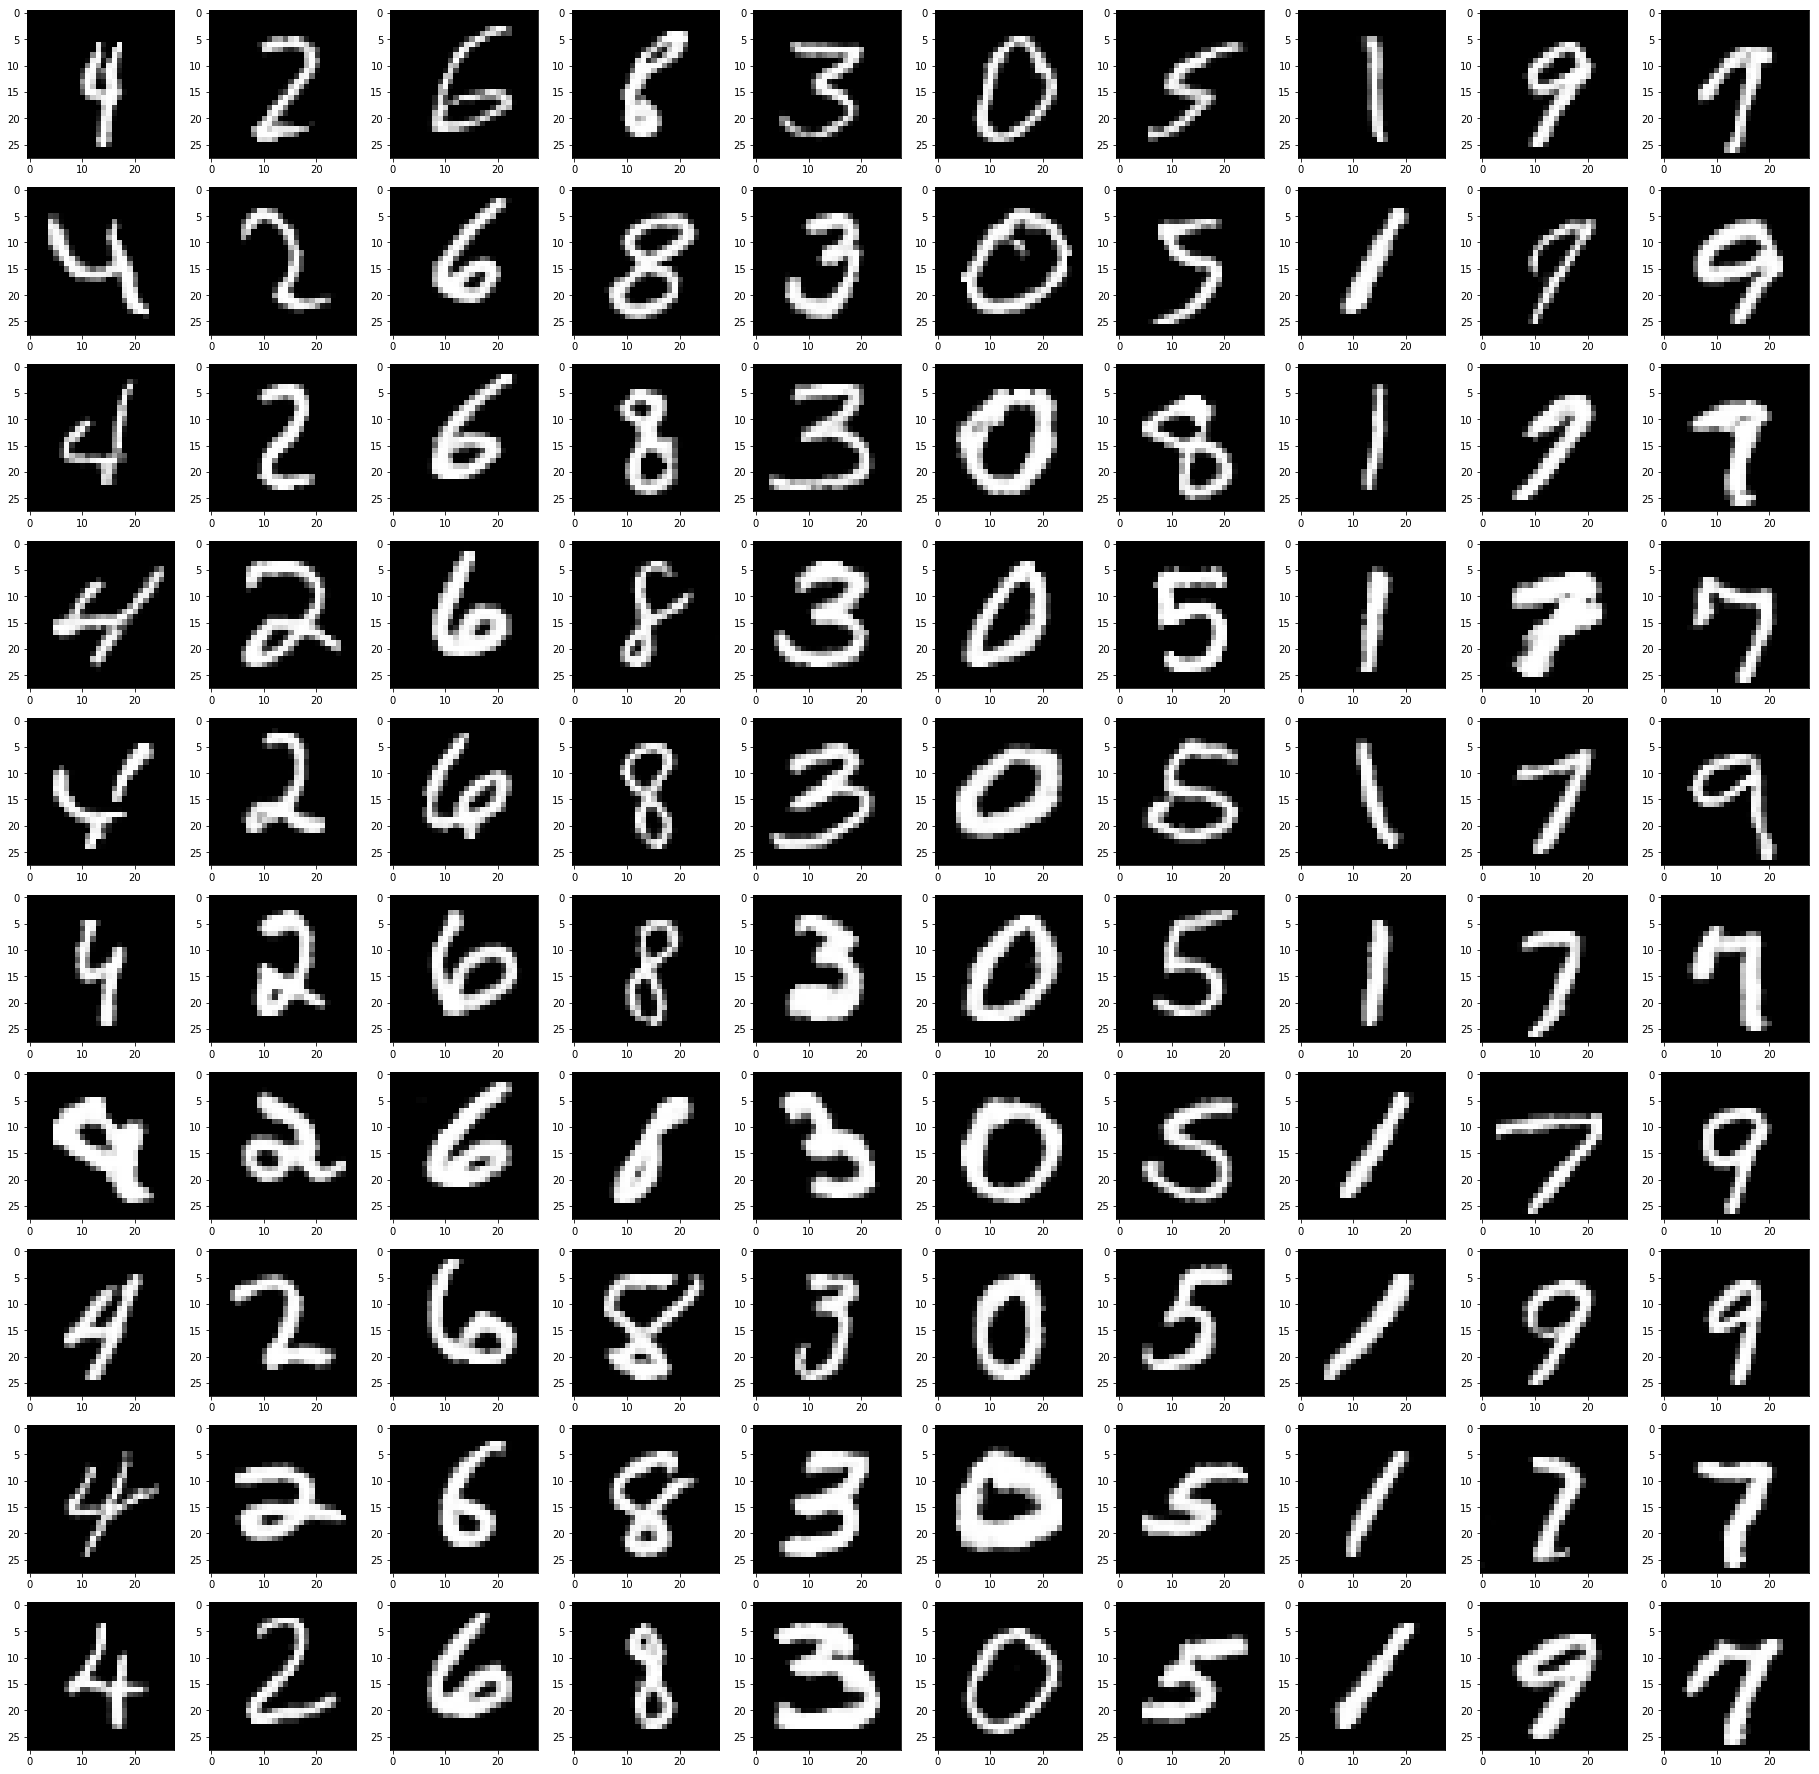

In [9]:
gen.load_state_dict(torch.load('mnist_gen.torch'))
dis.load_state_dict(torch.load('mnist_dis.torch'))
Q_cat.load_state_dict(torch.load('mnist_qcat.torch'))
Q_con.load_state_dict(torch.load('mnist_qcon.torch'))

plt.figure(0, figsize = (32, 32))

z = Variable(torch.randn(100, z_len)).cuda()

cat_noise = Variable(torch.arange(0, 10).repeat(10).long()).cuda()
onehot_noise = Variable(torch.zeros(100, 10)).cuda()
onehot_noise.data.scatter_(1, cat_noise.data.view(-1, 1), 1)

#con_noise = Variable(torch.randn(100, c2_len)).cuda()
con_noise = Variable(torch.rand(100, c2_len)).cuda() * 2 - 1

z = torch.cat([z, onehot_noise, con_noise], dim = 1)
out_gen = gen(z)

for i in range(10):
    for j in range(10):
        idx = i * 10 + j + 1
        plt.subplot(10, 10, idx)
        plt.imshow(np.round(out_gen[idx - 1, 0].cpu().data.numpy() * 255), cmap = 'gray')


In [10]:
# Run the discriminator on the test data and check the score
# We have to figure out the right permutation & clustering of the outputs from the trainset
# First we'll figure out the permutations
data = Variable(x_train[:1000]).float().cuda() / 255
targets = Variable(y_train[:1000]).float().cuda()

_, hid = dis(data)
Q_categorical = F.softmax(Q_cat(hid))

_, Q_logits = torch.max(Q_categorical, dim = 1)
_, y_logits = torch.max(targets, dim = 1)

permutation_matrix = torch.zeros(10, 10)
for i in range(10):
    mask = (Q_logits == i)

    match, _ = torch.mode(torch.masked_select(y_logits, mask))
    match = int(match.data.cpu().numpy())

    permutation_matrix[i, match] = 1
    print(i, 'to', match)

0 to 4
1 to 2
2 to 6
3 to 8
4 to 3
5 to 0
6 to 5
7 to 1
8 to 7
9 to 9


In [12]:
# Now in python you can multiply matrices with @
Q_test = F.softmax(Q_cat(dis(Variable(x_test).cuda().float() / 255)[1]))
Q_test = Q_test @ Variable(permutation_matrix).cuda().float()
_, Q_logits_test = torch.max(Q_test, dim = 1)
_, y_logits_test = torch.max(y_test, dim = 1)

print(torch.mean((y_logits_test.cuda() == Q_logits_test.data).float()))

0.8737000226974487
